In [1]:
import pandas as pd
df_fiqa = pd.read_csv("df_fiqa.csv", index_col = 0)

# Convert to Glove numeric vector (6B-300d) and perform padding

In [2]:
def read_glove_vecs(glove_file):
    '''
    This function is to create 3 Dictionaries that can interact with the glove pre-trained weightings
    Input:
        glove_file: the directory of the pre-trained file
    Output:
        words_to_index: A directory that can use words as name and return back the index
        index_to_words: A directory that can use index as name and return back the words
        word_to_vec_map: A directory that can use words as name and directly return the Vector mapping
    '''
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def sentences_to_indices(X, word_to_index, Tx):
    """
    This function is to converts an array of sentences into an array of indices corresponding to words in the sentences.
    The output shape should match with the embedding dimension.
    
    Input:
        X: array of sentences (strings), of shape (m, 1), i.e. m samples.
        word_to_index: a dictionary called for converting word into index
        Tx: maximum number of words in a sentence. Sentences exceeds this number will be cut 
    
    Returns:
    X_indices: array of indices corresponding to words in the sentences from X, of shape (m, Tx)
    """
    
    m = X.shape[0] # number of data in the dataset
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape 
    X_indices = np.zeros((m, Tx))
    
    for i in range(m):
        sentence_words = X[i].split() #split sentence into a list of word
        sentence_words = sentence_words[0:Tx] # Cut all Words Once it search the maximun lenght Tx
        
        j = 0 # initialize the counter of word in every sentence
        
        for w in sentence_words: # convert word into index and input in the (i,j) elements of X_indices
            try: # try to see if the word is in the glove corpus
                X_indices[i, j] = word_to_index[w]
                j = j+1
            except: #if not, skip it and left that (i,j) elements as 0
                j = j+1
    
    return X_indices

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.astype(int)]
    return Y



In [3]:
import numpy as np
glove_file = "./Raw data/glove.6B.300d.txt"

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_file)

from sklearn.model_selection import train_test_split

X_train_fiqa, X_test_fiqa, y_train_fiqa, y_test_fiqa = train_test_split(df_fiqa.text, df_fiqa.label, test_size = 0.2, random_state=234)

X_train_fiqa_text = X_train_fiqa.to_numpy()
X_train_fiqa_indixes = sentences_to_indices(X_train_fiqa_text, word_to_index, Tx = 50)  

X_test_fiqa_text = X_test_fiqa.to_numpy()
X_test_fiqa_indixes = sentences_to_indices(X_test_fiqa_text, word_to_index, Tx = 50)  

y_train_fiqa = y_train_fiqa.to_numpy()
y_test_fiqa = y_test_fiqa.to_numpy()


In [5]:
import keras 
from keras.layers.embeddings import Embedding
from keras import callbacks
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Input, SimpleRNN, Bidirectional, Dropout, BatchNormalization, LSTM
from matplotlib import pyplot as plt

In [6]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1    # adding 1 to fit Keras embedding, special requirement for using Keras
    emb_dim = word_to_vec_map["apple"].shape[0]      # get dimensionality pre-trained embedding
    
    # Initialize the embedding matrix 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # for every word, idx pair in word_to_index dictionary, map it to its vector representation  
    # and store in the emb matrix
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer and set it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer instance
    embedding_layer.build((None,)) # None is used for "Dont know how many data, m samples, will be pass through"
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [7]:
def transfer_model(source_model):
    
    inputs = source_model.layers[0].input

    # Propagate X through a Dense layer into 2 units
    X = Dense(1, activation = "tanh")(source_model.layers[-2].output)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = inputs, outputs = X)
    
    return model

# RNN model - FiQA - Fine Tuning Only

In [16]:
model = keras.models.load_model("./Model_callback/models/1L-RNN-64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               46720     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 120,047,149
Trainable params: 129
Non-trainable params: 120,047,020
_________________________________________________________________


In [17]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_ft_1L-RNN-64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_ft_1L-RNN-64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_ft_1L_RNN_64 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 7s 333ms/step - loss: 0.3466 - val_loss: 0.2536
Epoch 2/50
21/21 [==============================] - 7s 312ms/step - loss: 0.2928 - val_loss: 0.2349
Epoch 3/50
21/21 [==============================] - 7s 350ms/step - loss: 0.2583 - val_loss: 0.2190
Epoch 4/50
21/21 [==============================] - 7s 326ms/step - loss: 0.2350 - val_loss: 0.2094
Epoch 5/50
21/21 [==============================] - 7s 319ms/step - loss: 0.2208 - val_loss: 0.1965
Epoch 6/50
21/21 [==============================] - 7s 332ms/step - loss: 0.2038 - val_loss: 0.1909
Epoch 7/50
21/21 [==============================] - 7s 320ms/step - loss: 0.1905 - val_loss: 0.1846
Epoch 8/50
21/21 [==============================] - 7s 345ms/step - loss: 0.1826 - val_loss: 0.1817
Epoch 9/50
21/21 [==============================] - 6s 303ms/step - loss: 0.1786 - val_loss: 0.1800
Epoch 10/50
21/21 [==============================] - 7s 331ms/step - loss: 0.1664 - val_loss: 0.1723

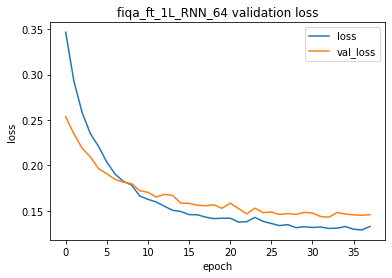

In [19]:
plt.plot(history_fiqa_ft_1L_RNN_64.history['loss'])
plt.plot(history_fiqa_ft_1L_RNN_64.history['val_loss'])
plt.title('fiqa_ft_1L_RNN_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [20]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 7ms/step - loss: 0.1356

Mean Squared Error on train set =  0.1355602741241455
7/7 [==============================] - 0s 7ms/step - loss: 0.1549

Mean Squared Error on test set =  0.1549316644668579


# RNN model - FiQA- Transfer As Initial

In [21]:
model = keras.models.load_model("./Model_callback/models/1L-RNN-64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               46720     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 120,047,149
Trainable params: 46,849
Non-trainable params: 120,000,300
_________________________________________________________________


In [22]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_1L-RNN-64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_1L-RNN-64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_1L_RNN_64 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 7s 354ms/step - loss: 0.2830 - val_loss: 0.2127
Epoch 2/50
21/21 [==============================] - 7s 352ms/step - loss: 0.1723 - val_loss: 0.1877
Epoch 3/50
21/21 [==============================] - 7s 333ms/step - loss: 0.1304 - val_loss: 0.1749
Epoch 4/50
21/21 [==============================] - 8s 371ms/step - loss: 0.1048 - val_loss: 0.1686
Epoch 5/50
21/21 [==============================] - 7s 330ms/step - loss: 0.0873 - val_loss: 0.1673
Epoch 6/50
21/21 [==============================] - 1s 46ms/step - loss: 0.0706 - val_loss: 0.1680
Epoch 7/50
21/21 [==============================] - 1s 44ms/step - loss: 0.0660 - val_loss: 0.1748
Epoch 8/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0566 - val_loss: 0.1686
Epoch 9/50
21/21 [==============================] - 8s 372ms/step - loss: 0.0445 - val_loss: 0.1656
Epoch 10/50
21/21 [==============================] - 7s 328ms/step - loss: 0.0427 - val_loss: 0.1552
Ep

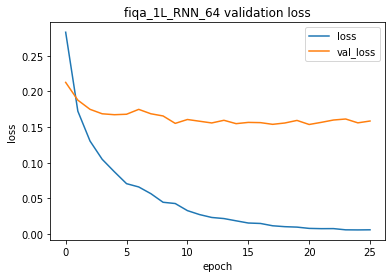

In [23]:
plt.plot(history_fiqa_1L_RNN_64.history['loss'])
plt.plot(history_fiqa_1L_RNN_64.history['val_loss'])
plt.title('fiqa_1L_RNN_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [24]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 8ms/step - loss: 0.0429

Mean Squared Error on train set =  0.0428551584482193
7/7 [==============================] - 0s 7ms/step - loss: 0.2013

Mean Squared Error on test set =  0.20133541524410248


# LSTM model - FiQA - Fine Tuning Only

In [25]:
model = keras.models.load_model("./Model_callback/models/1L-LSTM128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 120,439,853
Trainable params: 257
Non-trainable params: 120,439,596
_________________________________________________________________


In [27]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_ft_1L-LSTM-128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_ft_1L-LSTM-128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_ft_1L_LSTM_128 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 14s 678ms/step - loss: 0.2086 - val_loss: 0.1595
Epoch 2/50
21/21 [==============================] - 14s 686ms/step - loss: 0.1608 - val_loss: 0.1494
Epoch 3/50
21/21 [==============================] - 13s 622ms/step - loss: 0.1475 - val_loss: 0.1453
Epoch 4/50
21/21 [==============================] - 15s 699ms/step - loss: 0.1391 - val_loss: 0.1418
Epoch 5/50
21/21 [==============================] - 13s 610ms/step - loss: 0.1335 - val_loss: 0.1404
Epoch 6/50
21/21 [==============================] - 16s 749ms/step - loss: 0.1289 - val_loss: 0.1390
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1256 - val_loss: 0.1391
Epoch 8/50
21/21 [==============================] - 13s 610ms/step - loss: 0.1242 - val_loss: 0.1373
Epoch 9/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1202 - val_loss: 0.1380
Epoch 10/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1184 - val_loss: 0.138

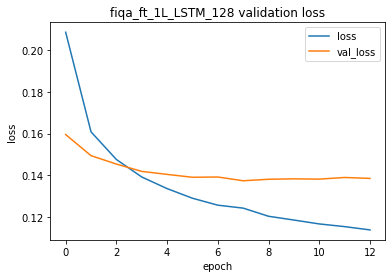

In [28]:
plt.plot(history_fiqa_ft_1L_LSTM_128.history['loss'])
plt.plot(history_fiqa_ft_1L_LSTM_128.history['val_loss'])
plt.title('fiqa_ft_1L_LSTM_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [29]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 3ms/step - loss: 0.1182

Mean Squared Error on train set =  0.11822573095560074
7/7 [==============================] - 0s 3ms/step - loss: 0.1340

Mean Squared Error on test set =  0.13399165868759155


# LSTM model - FiQA - Transfer as Initial

In [35]:
model = keras.models.load_model("./Model_callback/models/1L-LSTM128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 120,439,853
Trainable params: 439,553
Non-trainable params: 120,000,300
_________________________________________________________________


In [36]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_1L-LSTM-128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_1L-LSTM-128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.0002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_1L_LSTM_128 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 15s 694ms/step - loss: 0.1893 - val_loss: 0.1611
Epoch 2/50
21/21 [==============================] - 15s 731ms/step - loss: 0.1271 - val_loss: 0.1326
Epoch 3/50
21/21 [==============================] - 13s 621ms/step - loss: 0.0934 - val_loss: 0.1230
Epoch 4/50
21/21 [==============================] - 15s 708ms/step - loss: 0.0705 - val_loss: 0.1185
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0533 - val_loss: 0.1191
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0413 - val_loss: 0.1248
Epoch 7/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0306 - val_loss: 0.1273
Epoch 8/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0242 - val_loss: 0.1275
Epoch 9/50
21/21 [==============================] - 0s 9ms/step - loss: 0.0189 - val_loss: 0.1293


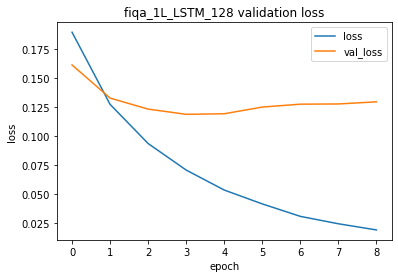

In [37]:
plt.plot(history_fiqa_1L_LSTM_128.history['loss'])
plt.plot(history_fiqa_1L_LSTM_128.history['val_loss'])
plt.title('fiqa_1L_LSTM_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [38]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 4ms/step - loss: 0.0437

Mean Squared Error on train set =  0.04369940608739853
7/7 [==============================] - 0s 4ms/step - loss: 0.1451

Mean Squared Error on test set =  0.14509537816047668


# 2L LSTM - FiQA - Fine Tuning Only

In [39]:
model = keras.models.load_model("./Model_callback/models/2L-LSTM128_128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[4].trainable = False
model2.layers[5].trainable = False
model2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)             

In [41]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_ft_2L-LSTM128_128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_ft_2L-LSTM128_128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_ft_2L_LSTM128_128 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 25s 1s/step - loss: 0.1964 - val_loss: 0.1393
Epoch 2/50
21/21 [==============================] - 25s 1s/step - loss: 0.1911 - val_loss: 0.1290
Epoch 3/50
21/21 [==============================] - 25s 1s/step - loss: 0.1710 - val_loss: 0.1239
Epoch 4/50
21/21 [==============================] - 25s 1s/step - loss: 0.1512 - val_loss: 0.1214
Epoch 5/50
21/21 [==============================] - 25s 1s/step - loss: 0.1484 - val_loss: 0.1193
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 0.1442 - val_loss: 0.1200
Epoch 7/50
21/21 [==============================] - 0s 9ms/step - loss: 0.1417 - val_loss: 0.1195
Epoch 8/50
21/21 [==============================] - 23s 1s/step - loss: 0.1443 - val_loss: 0.1173
Epoch 9/50
21/21 [==============================] - 26s 1s/step - loss: 0.1290 - val_loss: 0.1161
Epoch 10/50
21/21 [==============================] - 0s 9ms/step - loss: 0.1343 - val_loss: 0.1164
Epoch 11/50
21/21 [

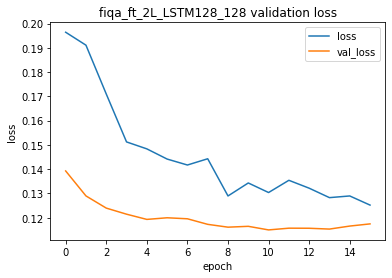

In [42]:
plt.plot(history_fiqa_ft_2L_LSTM128_128.history['loss'])
plt.plot(history_fiqa_ft_2L_LSTM128_128.history['val_loss'])
plt.title('fiqa_ft_2L_LSTM128_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [43]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 6ms/step - loss: 0.1130

Mean Squared Error on train set =  0.11295078694820404
7/7 [==============================] - 0s 5ms/step - loss: 0.1311

Mean Squared Error on test set =  0.1310618370771408


# 2L LSTM - FiQA - Transfer as Initial

In [44]:
model = keras.models.load_model("./Model_callback/models/2L-LSTM128_128")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)             

In [45]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_2L-LSTM128_128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_2L-LSTM128_128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.0002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_2L_LSTM128_128 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 26s 1s/step - loss: 0.2999 - val_loss: 0.1816
Epoch 2/50
21/21 [==============================] - 25s 1s/step - loss: 0.2298 - val_loss: 0.1716
Epoch 3/50
21/21 [==============================] - 26s 1s/step - loss: 0.1786 - val_loss: 0.1677
Epoch 4/50
21/21 [==============================] - 26s 1s/step - loss: 0.1653 - val_loss: 0.1598
Epoch 5/50
21/21 [==============================] - 26s 1s/step - loss: 0.1384 - val_loss: 0.1564
Epoch 6/50
21/21 [==============================] - 23s 1s/step - loss: 0.1114 - val_loss: 0.1522
Epoch 7/50
21/21 [==============================] - 27s 1s/step - loss: 0.1235 - val_loss: 0.1478
Epoch 8/50
21/21 [==============================] - 26s 1s/step - loss: 0.1099 - val_loss: 0.1398
Epoch 9/50
21/21 [==============================] - 0s 16ms/step - loss: 0.0980 - val_loss: 0.1491
Epoch 10/50
21/21 [==============================] - 0s 16ms/step - loss: 0.0927 - val_loss: 0.1406
Epoch 11/50
21/21

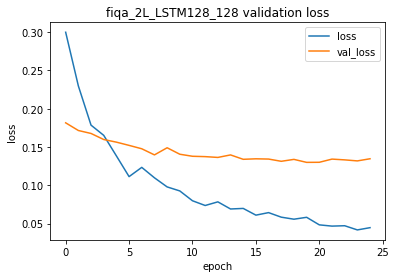

In [46]:
plt.plot(history_fiqa_2L_LSTM128_128.history['loss'])
plt.plot(history_fiqa_2L_LSTM128_128.history['val_loss'])
plt.title('fiqa_2L_LSTM128_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [47]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 6ms/step - loss: 0.0450

Mean Squared Error on train set =  0.04504041001200676
7/7 [==============================] - 0s 5ms/step - loss: 0.1345

Mean Squared Error on test set =  0.13454727828502655


# 3L-LSTM model - FiQA - Fine Tuning Only

In [48]:
model = keras.models.load_model("./Model_callback/models/3L-LSTM128_128_64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.layers[2].trainable = False
model2.layers[4].trainable = False
model2.layers[5].trainable = False
model2.layers[7].trainable = False
model2.layers[8].trainable = False
model2.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)         

In [49]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_ft_3L-LSTM128_128_64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_ft_3L-LSTM128_128_64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_ft_3L_LSTM128_128_64 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 36s 2s/step - loss: 0.2897 - val_loss: 0.1704
Epoch 2/50
21/21 [==============================] - 34s 2s/step - loss: 0.2208 - val_loss: 0.1700
Epoch 3/50
21/21 [==============================] - 39s 2s/step - loss: 0.2012 - val_loss: 0.1550
Epoch 4/50
21/21 [==============================] - 39s 2s/step - loss: 0.2080 - val_loss: 0.1503
Epoch 5/50
21/21 [==============================] - 36s 2s/step - loss: 0.2018 - val_loss: 0.1474
Epoch 6/50
21/21 [==============================] - 36s 2s/step - loss: 0.1822 - val_loss: 0.1426
Epoch 7/50
21/21 [==============================] - 36s 2s/step - loss: 0.1743 - val_loss: 0.1402
Epoch 8/50
21/21 [==============================] - 33s 2s/step - loss: 0.1741 - val_loss: 0.1370
Epoch 9/50
21/21 [==============================] - 37s 2s/step - loss: 0.1584 - val_loss: 0.1343
Epoch 10/50
21/21 [==============================] - 39s 2s/step - loss: 0.1594 - val_loss: 0.1331
Epoch 11/50
21/21 [

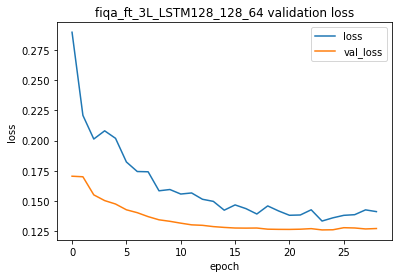

In [50]:
plt.plot(history_fiqa_ft_3L_LSTM128_128_64.history['loss'])
plt.plot(history_fiqa_ft_3L_LSTM128_128_64.history['val_loss'])
plt.title('fiqa_ft_3L_LSTM128_128_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [51]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 8ms/step - loss: 0.1281

Mean Squared Error on train set =  0.1280776411294937
7/7 [==============================] - 0s 7ms/step - loss: 0.1361

Mean Squared Error on test set =  0.13607138395309448


# 3L-LSTM model - FiQA - Transfer as Initial

In [52]:
model = keras.models.load_model("./Model_callback/models/3L-LSTM128_128_64")
model2 = transfer_model(model)
model2.layers[1].trainable = False
model2.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)         

In [53]:
my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/fiqa_3L-LSTM128_128_64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/fiqa_3L-LSTM128_128_64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam(learning_rate = 0.0002) 
model2.compile(loss='mean_squared_error', optimizer = opt)
history_fiqa_3L_LSTM128_128_64 = model2.fit(X_train_fiqa_indixes, y_train_fiqa, epochs = 50, batch_size = 32, 
                                             validation_split =  1/4, shuffle=True, callbacks=my_callbacks)

Epoch 1/50
21/21 [==============================] - 37s 2s/step - loss: 0.3707 - val_loss: 0.2168
Epoch 2/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2665 - val_loss: 0.2214
Epoch 3/50
21/21 [==============================] - 0s 22ms/step - loss: 0.2261 - val_loss: 0.2192
Epoch 4/50
21/21 [==============================] - 34s 2s/step - loss: 0.2018 - val_loss: 0.1881
Epoch 5/50
21/21 [==============================] - 39s 2s/step - loss: 0.1954 - val_loss: 0.1657
Epoch 6/50
21/21 [==============================] - 0s 22ms/step - loss: 0.1608 - val_loss: 0.1659
Epoch 7/50
21/21 [==============================] - 37s 2s/step - loss: 0.1441 - val_loss: 0.1446
Epoch 8/50
21/21 [==============================] - 33s 2s/step - loss: 0.1425 - val_loss: 0.1373
Epoch 9/50
21/21 [==============================] - 38s 2s/step - loss: 0.1432 - val_loss: 0.1227
Epoch 10/50
21/21 [==============================] - 40s 2s/step - loss: 0.1178 - val_loss: 0.1163
Epoch 11/50
21/2

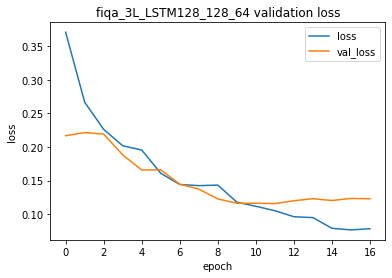

In [54]:
plt.plot(history_fiqa_3L_LSTM128_128_64.history['loss'])
plt.plot(history_fiqa_3L_LSTM128_128_64.history['val_loss'])
plt.title('fiqa_3L_LSTM128_128_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [55]:
loss = model2.evaluate(X_train_fiqa_indixes, y_train_fiqa)
print()
print("Mean Squared Error on train set = ", loss)

loss = model2.evaluate(X_test_fiqa_indixes, y_test_fiqa)
print()
print("Mean Squared Error on test set = ", loss)

28/28 [==============================] - 0s 8ms/step - loss: 0.0520

Mean Squared Error on train set =  0.05200758948922157
7/7 [==============================] - 0s 7ms/step - loss: 0.1355

Mean Squared Error on test set =  0.1354910284280777
